In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import keras as ks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM

# read data

In [2]:
df = pd.read_json (r'./corpora-DO_NOT_SHARE/unified-dataset.json', lines=True)

In [3]:
df['source'].unique()

array(['tec', 'ssec', 'dailydialogues', 'fb-valence-arousal-anon',
       'affectivetext', 'emotiondata-aman', 'electoraltweets',
       'grounded_emotions', 'emotion-cause', 'isear', 'emoint',
       'crowdflower', 'tales-emotion'], dtype=object)

In [4]:
# select only needed sources
df = df.loc[(df['source'] == "tec") | (df['source'] == "crowdflower")]

In [5]:
# remove not needed columns
df = df.drop(columns=['id', 'VAD', 'split', 'domain', 'labeled', 'optional', 'annotation_procedure', 'emotion_model'])

In [6]:
# convert emotions dict to columns
df = df.join(df['emotions'].apply(pd.Series))

In [7]:
# remove not needed columns
df = df.drop(columns=['emotions', 'trust', 'love', 'noemo', 'confusion', 'anticipation', 'shame', 'guilt', 'anticipation'])

In [8]:
# remove not annotated texts
df = df.loc[(df['joy'] != 0) | (df['anger'] != 0) | (df['sadness'] != 0) | (df['disgust'] != 0) | (df['fear'] != 0) | (df['surprise'] != 0)]

# preprocessing

In [9]:
embeddings_index = {}

num_words = 10000
maxlen = df.text.str.split().apply(len).max()
embedding_dim = 100

In [10]:
df.columns

Index(['source', 'text', 'joy', 'anger', 'sadness', 'disgust', 'fear',
       'surprise'],
      dtype='object')

In [11]:
#data_source = df
#data_source = df.loc[(df['source'] == "tec")]
data_source = df.loc[(df['source'] == "crowdflower")]

In [12]:
# select x and y
samples = data_source['text']
labels = data_source.loc[:, (data_source.columns != 'text') & (data_source.columns != 'source')].values

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(samples)

sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index

padded_sequences = sequence.pad_sequences(sequences, maxlen)

In [13]:
f = open("glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [14]:
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [15]:
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# data split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.33, random_state=42)

In [17]:
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
class_weights = dict(enumerate(class_weights))

/nix/store/3ldnan7i65i6qwqghrklyqg8mb7ina85-python3-3.8.5-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2 3 4 5], y=[5 2 4 ... 4 0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


# model training

In [18]:
model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Bidirectional(LSTM(100)))
#model.add(Dense(36))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_test,y_test),
                    class_weight=class_weights)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 36)                7236      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 222       
Total params: 1,168,258
Trainable params: 168,258
Non-trainable params: 1,000,000
_________________________________________________________________
None
Epoch 1/20
139/139 [==============================] - 20s 141ms/step - loss: 1.7438 - accuracy: 0.2590 - val_loss: 1.7145 - val_accuracy: 0.2481
Epoch 2/20
139/139 [==============================] - 18s 127ms/step - loss: 1.6225 - ac

In [19]:
def nn_predict_single(text):
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = sequence.pad_sequences(seq, maxlen, padding="post")
    model_output = model.predict(padded_seq)
    return np.argmax(model_output)
def nn_predict_many(texts):
    lst = []
    for row in texts:
        seq = tokenizer.texts_to_sequences([row])
        padded_seq = sequence.pad_sequences(seq, maxlen, padding="post")
        lst.append(padded_seq)
    print(len(lst))
    model_output = model.predict(lst)
    print(model_output)
    return np.argmax(model_output, axis=1)

# history plot

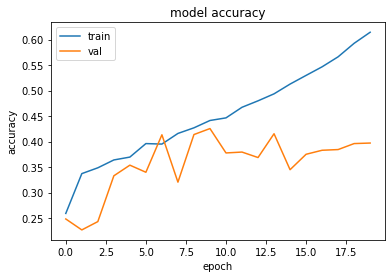

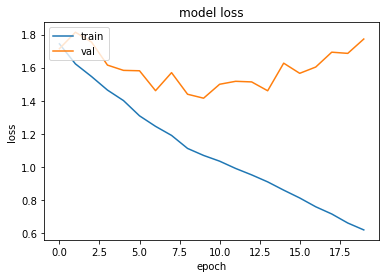

In [20]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# scores

In [21]:
from collections import Counter

correct = 0

#data_source = df
data_source = df.loc[(df['source'] == "tec")]
#data_source = df.loc[(df['source'] == "crowdflower")]

val_texts = data_source['text']
y_test = data_source.loc[:, (data_source.columns != 'text') & (data_source.columns != 'source')].values


print("Distribution of classes: ")
_, idx, count = np.unique(y_test.argmax(1), return_counts=1, return_index=1)
print({tuple(i):j for i,j in zip(y_test[idx],count)})

#y_test = []
y_pred = []

predictions = nn_predict_many(val_texts)
print(predictions)
for i in range(0,len(val_texts)):
    y_pred.append(predictions[i])
    if predictions[i] == np.argmax(y_test[i]):
        correct += 1

"""
for i in range(0,len(val_texts)):
    prediction = nn_predict_single(val_texts[i])
    y_pred.append(prediction)
    if prediction == np.argmax(y_test[i]):
        correct += 1
"""

Distribution of classes: 
{(1.0, 0.0, 0.0, 0.0, 0.0, 0.0): 8237, (0.0, 1.0, 0.0, 0.0, 0.0, 0.0): 1555, (0.0, 0.0, 1.0, 0.0, 0.0, 0.0): 3830, (0.0, 0.0, 0.0, 1.0, 0.0, 0.0): 761, (0.0, 0.0, 0.0, 0.0, 1.0, 0.0): 2816, (0.0, 0.0, 0.0, 0.0, 0.0, 1.0): 3849}
21048


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
print("Accuracy:")
print(correct/len(val_texts))
print("F1 score micro")
print(f1_score(y_test, y_pred, average="micro"))
print("F1 score macro")
print(f1_score(y_test, y_pred, average="macro"))

# Look at class wise score
print(classification_report(y_test, y_pred, digits=3))

# confusion matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

tags = ['joy', 'anger', 'sadness', 'disgust', 'fear', 'surprise']

cm = confusion_matrix(y_test,y_pred,labels=tags)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(tags))
    plt.xticks(tick_marks, tags, rotation=45)
    plt.yticks(tick_marks, tags)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)
plt.show()